In [4]:
import os
import functools

import numpy as np
import matplotlib.pyplot as plt
# %matplotlib tk
from matplotlib import cm
import seaborn as sns

from tests.metaworld.envs.mujoco.sawyer_xyz.utils import trajectory_summary
from tests.metaworld.envs.mujoco.sawyer_xyz.test_scripted_policies import ALL_ENVS, test_cases_latest_nonoise

sns.set()

In [5]:
def sample_trajectories_from(env, policy, act_noise_pct, iters=100):
    sampled_rewards = []
    sampled_returns = []
    sampled_first_successes = []

    for _ in range(iters):
        s = trajectory_summary(env, policy, act_noise_pct, end_on_success=False)
        sampled_rewards.append(s[1])
        sampled_returns.append(s[2])
        sampled_first_successes.append(s[3])

    sampled_rewards = np.vstack(sampled_rewards)
    sampled_returns = np.vstack(sampled_returns)
    sampled_first_successes = np.array(sampled_first_successes)

    return sampled_rewards, sampled_returns, sampled_first_successes


def plot(rewards, returns, tag, dim):
    x = np.linspace(0, 1, rewards.shape[0])
    y = np.arange(rewards.shape[1])
    X, Y = np.meshgrid(x, y)
    
    fig = plt.figure(figsize=(12, 5))

    Z = rewards.T
    norm = plt.Normalize(Z.min(), Z.max())
    colors = cm.viridis(norm(Z))
    rcount, ccount, _ = colors.shape

    ax0 = fig.add_subplot(121, projection='3d')
    surf = ax0.plot_surface(X, Y, Z, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)

    surf.set_facecolor((0,0,0,0))
    ax0.set_xlabel(f'Noise Percent in Action Dim {dim}')
    ax0.set_ylabel('Time Steps')
    ax0.set_zlabel('Rewards')
    ax0.set_zscale('symlog')

    Z = returns.T
    norm = plt.Normalize(Z.min(), Z.max())
    colors = cm.viridis(norm(Z))
    rcount, ccount, _ = colors.shape

    ax1 = fig.add_subplot(122, projection='3d')
    surf = ax1.plot_surface(X, Y, Z, rcount=rcount, ccount=ccount, facecolors=colors, shade=False)

    surf.set_facecolor((0,0,0,0))
    ax1.set_xlabel(f'Noise Percent in Action Dim {dim}')
    ax1.set_ylabel('Time Steps')
    ax1.set_zlabel('Returns')
    ax1.set_zscale('symlog')

    plt.subplots_adjust(top=.85)
    fig.suptitle(f'{tag}')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    ax0.view_init(30, +32)
    ax1.view_init(30, -45)
    plt.show()
    if not os.path.exists('figures'):
        os.mkdir('figures')
    fig.savefig(f'figures/{tag}_vary_noise_rewards_returns.jpg')

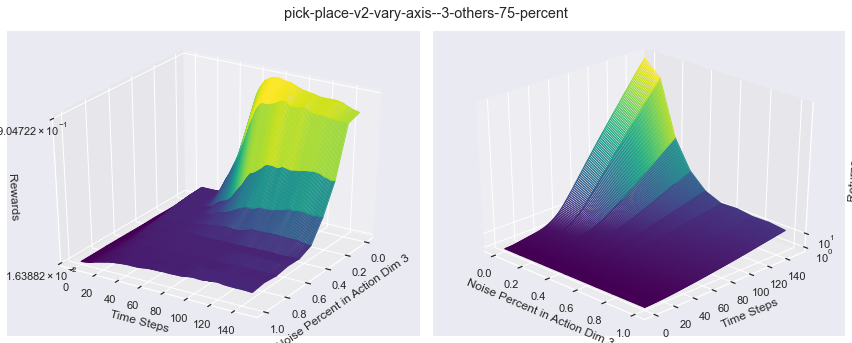

In [7]:
config = [
#     ['button-press-topdown-v1', 3],
    ['pick-place-v2', 3],
#     ['reach-v2', 3],
#     ['window-open-v2', 3],
#     ['sweep-v1', 3],
#     ['sweep-into-v1', 3],
#     ['shelf-place-v2', 3],
#     ['push-v2', 3],
#     ['peg-insert-side-v2', 3],
#     ['lever-pull-v2', 3],
]

for env, axis in config:
    tag = env + '-vary-axis-' + str(1-4)
    policy = functools.reduce(lambda a,b : a if a[0] == env else b, test_cases_latest_nonoise)[1]
    env = ALL_ENVS[env]()
    env._partially_observable = False
    env._freeze_rand_vec = False
    env._set_task_called = True

    sampled_rewards, sampled_returns = [], []
    noise = np.full(4, .75)
    tag = tag + '-others-75-percent'

    for i in np.linspace(0, 1, 10):
        noise = np.full(4, i)

        rew, ret, _ = sample_trajectories_from(env, policy, noise)
        sampled_rewards.append(rew.mean(axis=0))
        sampled_returns.append(ret.mean(axis=0))

    sampled_rewards = np.vstack(sampled_rewards)
    sampled_returns = np.vstack(sampled_returns)

    plot(sampled_rewards, sampled_returns, tag, axis)